<a href="https://colab.research.google.com/github/xiongnemo/tongji-ids-captcha-crack/blob/master/tongji_ids_captcha_crack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !sudo apt update && sudo apt upgrade
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,294 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [2]:
class CaptchaLengthAssertionFailedError(Exception):
    pass

In [3]:
# import the necessary packages
import numpy as np
import argparse
import cv2
from google.colab.patches import cv2_imshow
import pytesseract

# load the image from disk
raw_image = cv2.imread("nN5K.png")
assert raw_image.shape == (69, 200, 3)

In [4]:
def try_to_find_rotate_angle(image, index: int):
    # convert the image to grayscale and flip the foreground
    # and background to ensure foreground is now "white" and
    # the background is "black"
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)
    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle
    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # show the output image
    # print("[INFO] angle: {:.3f}".format(angle))
    img_rgb = cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(gray, 252, 255, cv2.THRESH_BINARY)
    cv2_imshow(rotated)
    cv2_imshow(gray)
    cv2_imshow(blackAndWhiteImage)
    return img_rgb, blackAndWhiteImage

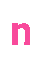

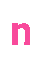

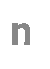

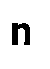

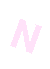

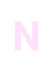

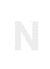

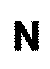

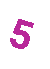

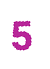

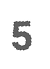

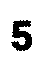

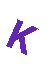

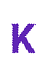

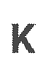

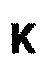

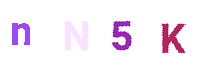

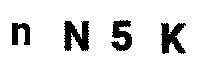

nN5K


In [5]:
blank_image = np.zeros((69,200,3), np.uint8)
blank_image_bw = np.zeros((69,200), np.uint8)
for i in range(4):
    crop_img = raw_image[0:0+69, 0+i*50:0+50+i*50]
    cv2_imshow(crop_img)
    rgb_image, bw_image = try_to_find_rotate_angle(crop_img, i)
    y_offset = 0
    x_offset = 50 * i
    blank_image[y_offset:y_offset+rgb_image.shape[0], x_offset:x_offset+rgb_image.shape[1]] = rgb_image
    blank_image_bw[y_offset:y_offset+bw_image.shape[0], x_offset:x_offset+bw_image.shape[1]] = bw_image
cv2_imshow(blank_image)
cv2_imshow(blank_image_bw)
cv2.imwrite("blank_image_bw.png", blank_image_bw)
raw_output = pytesseract.image_to_string(blank_image_bw)
CAPTCHA_STRING = ''.join(filter(str.isalnum, raw_output))
if len(CAPTCHA_STRING) != 4:
    raise CaptchaLengthAssertionFailedError("The length of tesseract's result is not 4. It's recommended to try another one.")
else:
    print(CAPTCHA_STRING)

In [6]:
len(CAPTCHA_STRING)

4

In [7]:
for i in CAPTCHA_STRING:
    print(ord(i))

110
78
53
75


In [8]:
!tesseract ./blank_image_bw.png stdout

Warning. Invalid resolution 0 dpi. Using 70 instead.
Estimating resolution as 394
nN5 K
